# Telecom Customer Churn Prediction

Churn is the measure of how many customers stop using a product. This can be measured based on actual usage or failure to renew (when the product is sold using a subscription model). Often evaluated for a specific period of time, there can be a monthly, quarterly, or annual churn rate.


When new customers begin buying and/or using a product, each new user contributes to a product’s growth rate. Inevitably some of those customers will eventually discontinue their usage or cancel their subscription; either because they switched to a competitor or alternative solution, no longer need to product’s functions, they’re unhappy with their user experience, or they can no longer afford or justify the cost. The customers that stop using/paying are the “churn” for a given period of time.


This dataset is available on Kaggle:https://www.kaggle.com/datasets/blastchar/telco-customer-churn


Our goal here is
* to predict which customer is going to churn with various classification supervised machine learning algorithms
* to evaluate which algorithms perform the best, so they can be used for further prediction on the upcoming data.

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE 

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

### Load dataset

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 1. Data Understanding

### 1.1. General Information and Missing Values

In [60]:
#show data type and null values in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#### Observation:

* There is no null data in every column
* Each column has been in appropiate data type, except TotalCharges
* TotalCharges should be a numerical data type

In [3]:
#convert totalcharges column from object to numerical
df.drop(df[df['TotalCharges'].str.contains(' ')].index, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

### 1.2. Statistical Summary and Univariate Analysis

In [4]:
#divide column into numerical and categorical
numerical = []
categorical = []

for column in df.columns:
    if df[column].dtypes == 'object':
        categorical.append(column)
    elif (df[column].dtypes == 'float64') or (df[column].dtypes == 'int64'):
        numerical.append(column)

categorical, numerical

(['customerID',
  'gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'Churn'],
 ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'])

### 1.2.1. Numerical Columns

In [5]:
#statistical summary for numerical column
df[numerical].describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


#### Observation:

* SeniorCitizen is binary column, where 1 shows senior citizen and 0 shows senior citizen.
* tenure ranges between 1 month until 72 months or 6 years, with average of 32 months and median 29 months or around 2 years and 5-8 months. The difference between median and mean is quite small, may slightly right skewed (not symmetrical).
* MonthlyCharges ranges between 18.25 until 18.75 or around 100 dollars. The difference between median and mean shows that the distribution is not symmetrical or slightly left skewed.
* TotalCharges ranges between 18.8 until 8684.8, such a huge difference. It may differ based on the tenure length of each customer. The distribution is also not symmetrical.

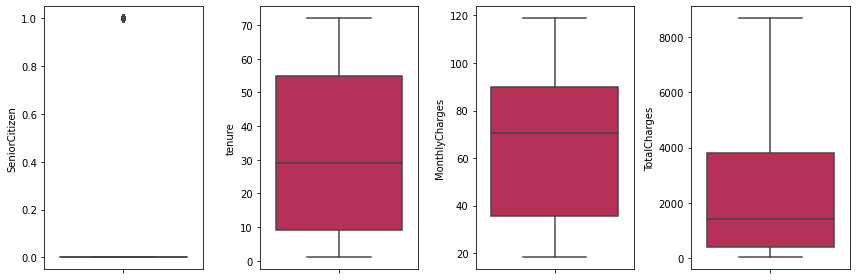

In [6]:
#plot boxplot to detect outliers
plt.figure(figsize=(12, 4))

for i in range(len(numerical)):
    plt.subplot(1, len(numerical), i+1)
    sns.boxplot(y=df[numerical[i]], palette='rocket')
    plt.tight_layout()

#### Observation:

* Since SeniorCitizen is binary valued column, we do not need to handle the outlier. There is much smaller senior customers than non senior customers
* There is no outliers in other columns

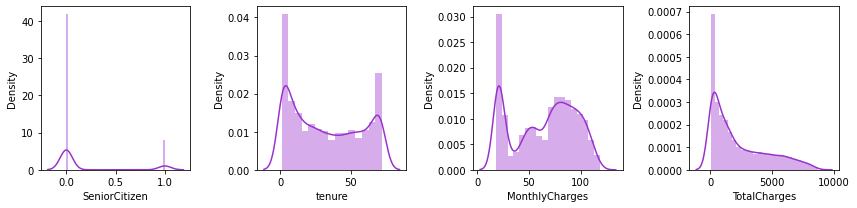

In [10]:
#draw kde plot to see each column distribution
plt.figure(figsize=(12, 3))

for i in range(len(numerical)):
    plt.subplot(1, len(numerical), i+1)
    sns.distplot(x=df[numerical[i]], color='darkorchid')
    plt.xlabel(numerical[i])
    plt.tight_layout()

#### Observation:

* There are much more non senior customers than senior customers
* There are more customers who has shorter tenure. Seems there are two groups of customer based on tenure, new customers and loyal customer who has been in Telco for more than 3 years.
* There are many customers with lower Monthly Charges. There are 3 groups of customer: low MonthlyCharges around 20 dollar, mid (around 50 dollars), and the last higher (around 100 dollars).
* There are much more customers with lower TotalCharges. It corresponds to more customers with lower MonthlyCharges.

### 1.2.2. Categorical Columns

In [11]:
df[categorical].describe()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032
unique,7032,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3549,3639,4933,6352,3385,3096,3497,3087,3094,3472,2809,2781,3875,4168,2365,5163


In [12]:
#show value counts for categorical column
for column in categorical:
    print(f'value counts for {column} column :\n', df[column].value_counts(), '\n')

value counts for customerID column :
 7590-VHVEG    1
0265-PSUAE    1
2956-GGUCQ    1
6008-NAIXK    1
5956-YHHRX    1
             ..
7874-ECPQJ    1
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
3186-AJIEK    1
Name: customerID, Length: 7032, dtype: int64 

value counts for gender column :
 Male      3549
Female    3483
Name: gender, dtype: int64 

value counts for Partner column :
 No     3639
Yes    3393
Name: Partner, dtype: int64 

value counts for Dependents column :
 No     4933
Yes    2099
Name: Dependents, dtype: int64 

value counts for PhoneService column :
 Yes    6352
No      680
Name: PhoneService, dtype: int64 

value counts for MultipleLines column :
 No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64 

value counts for InternetService column :
 Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64 

value counts for OnlineSecurity column :
 No                     3497


#### Observation:

* Columns like Partner, Dependents, PhoneService, Paperless Billing and Churn have binary value, apparantly Yes or No.
* The other columns have 3 different values.

In [13]:
#drop customerID column
categorical.remove('customerID')

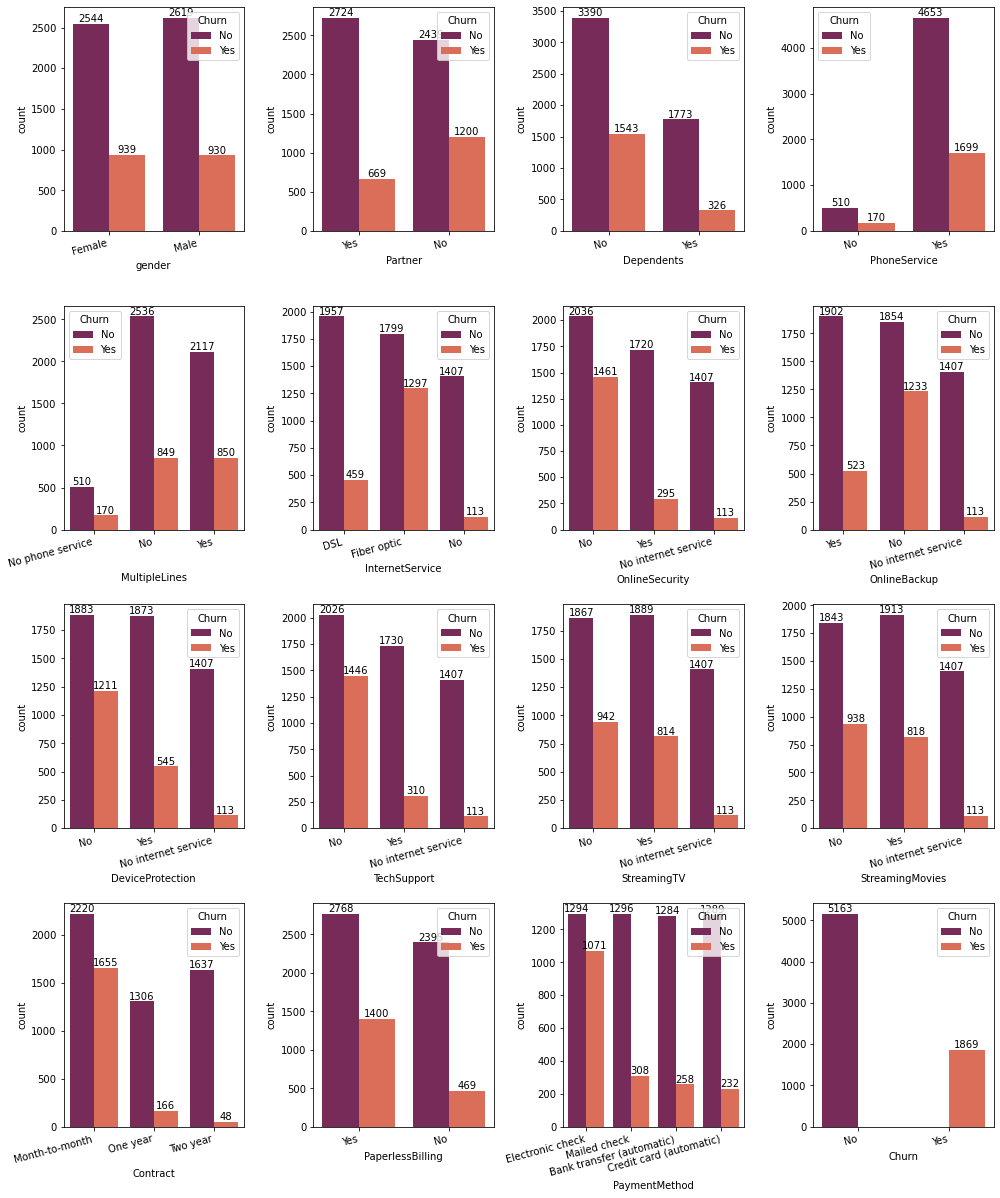

In [14]:
#draw countplot for categorical columns to show the frequency of different value in each column

#countplot
plt.figure(figsize=(14, 20))
for i in range(len(categorical)):
    plt.subplot(len(categorical)//3, 4, i+1)
    ax = sns.countplot(x=df[categorical[i]], hue=df['Churn'], palette='rocket')
    plt.xticks(rotation=15, ha='right')
    plt.xlabel(categorical[i])
    plt.bar_label(ax.containers[0])
    plt.bar_label(ax.containers[1])
    plt.tight_layout()

### 1.3. Duplicated Values

In [15]:
#check duplicated values
df.duplicated().sum()

0

## 2. Data Preprocessing

In [16]:
#copy data into another dataframe for modelling
data = df.copy()
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 2.1. Label Encoding

This encoding is used for columns that has binary value

In [17]:
#label encoding for column that has binary value
column1 = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
map_class = {'Yes':1, 'No':0}

for column in column1:
    data[column] = data[column].map(map_class)

data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,No,...,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,Yes,...,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,Yes,...,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,No,...,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


### 2.2. Frequency Encoding

This encoding is used for other categorical columns. This encoding currently perform the best for this modelling.

In [18]:
#frequency encoding for other categorical column
column2 = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
           'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

for column in column2:
    freq_et = data[column].value_counts().reset_index()
    freq_et.rename(columns = {'index': column, column: f'freq_{column}'}, inplace=True)
    freq_et[f'pct_freq_{column}'] = round(freq_et[f'freq_{column}']/freq_et[f'freq_{column}'].sum()*100, 2)
    data = data.merge(freq_et[[column, f'pct_freq_{column}']], on=column, how='inner')
    
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,pct_freq_MultipleLines,pct_freq_InternetService,pct_freq_OnlineSecurity,pct_freq_OnlineBackup,pct_freq_DeviceProtection,pct_freq_TechSupport,pct_freq_StreamingTV,pct_freq_StreamingMovies,pct_freq_Contract,pct_freq_PaymentMethod
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,No,...,9.67,34.36,49.73,34.49,44.0,49.37,39.95,39.55,55.11,33.63
1,6235-VDHOM,Female,1,0,0,5,0,No phone service,DSL,No,...,9.67,34.36,49.73,34.49,44.0,49.37,39.95,39.55,55.11,33.63
2,0811-GSDTP,Female,0,0,1,13,0,No phone service,DSL,No,...,9.67,34.36,49.73,34.49,44.0,49.37,39.95,39.55,55.11,33.63
3,6637-KYRCV,Female,0,1,1,5,0,No phone service,DSL,No,...,9.67,34.36,49.73,34.49,44.0,49.37,39.95,39.55,55.11,33.63
4,1432-FPAXX,Female,0,0,0,29,0,No phone service,DSL,No,...,9.67,34.36,49.73,34.49,44.0,49.37,39.95,39.55,55.11,33.63


In [19]:
#drop the encoded column
data = data.drop(columns = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
           'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'])

In [20]:
#drop customerID column
data = data.drop(columns = ['customerID'])

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SeniorCitizen              7032 non-null   int64  
 1   Partner                    7032 non-null   int64  
 2   Dependents                 7032 non-null   int64  
 3   tenure                     7032 non-null   int64  
 4   PhoneService               7032 non-null   int64  
 5   PaperlessBilling           7032 non-null   int64  
 6   MonthlyCharges             7032 non-null   float64
 7   TotalCharges               7032 non-null   float64
 8   Churn                      7032 non-null   int64  
 9   pct_freq_gender            7032 non-null   float64
 10  pct_freq_MultipleLines     7032 non-null   float64
 11  pct_freq_InternetService   7032 non-null   float64
 12  pct_freq_OnlineSecurity    7032 non-null   float64
 13  pct_freq_OnlineBackup      7032 non-null   float

In [21]:
#check if data is balanced
df['Churn'].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

The data is imbalance, so we need to handle it first before split it into train and test data.

### 2.3. Handle Imbalanced Data

We can handle imbalanced data by undersampling or oversampling. Oversampling is when the data from the fewer class (here is the churned customer) is added to adjust the class distribution of a data set.

In [22]:
from imblearn import over_sampling

feature = data.drop(columns='Churn')
target = data[['Churn']]

# Overampling with smote
X_over_smote, y_over_smote = over_sampling.SMOTE(random_state=42).fit_resample(feature, target)

In [23]:
#show data after oversampling

print(f'''Shape of X before SMOTE: {feature.shape}
Shape of X after SMOTE: {X_over_smote.shape}''')

print('\nBalance of positive and negative classes (%):')
y_over_smote.value_counts(normalize=True) * 100


Shape of X before SMOTE: (7032, 19)
Shape of X after SMOTE: (10326, 19)

Balance of positive and negative classes (%):


Churn
0        50.0
1        50.0
dtype: float64

### 2.4. Split Data into Train-Test

In [33]:
#Split data into train and test
from sklearn.model_selection import train_test_split

feature = data.drop(columns='Churn')
target = data[['Churn']]

#split data to pretrain-test
feature_data_train, feature_data_test, target_data_train, target_data_test = train_test_split(
    X_over_smote, y_over_smote, test_size = 0.30, random_state = 42)

## 3. Modelling 

There are 4 classification of algorithms that we use here: Logistic Regression, Decision Tree, Random Forest, and K-Nearest Neighbour. Later, we will evaluate which algorithm is the best.

### 3.1. Logistic Regression

In [34]:
#Logistic Regresion
from sklearn.linear_model import LogisticRegression

# train the model
X_train = feature_data_train.to_numpy()
y_train = target_data_train.to_numpy()
y_train = y_train.reshape(len(y_train),)

# define the model
logreg = LogisticRegression(random_state=42)

#fit the model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

### 3.2. Decision Tree

In [37]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier 

# train the model
X_train = feature_data_train.to_numpy()
y_train = target_data_train.to_numpy()
y_train = y_train.reshape(len(y_train),)

# define the model
dt = DecisionTreeClassifier(random_state=67)

#fit the model
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=67)

### 3.3. Random Forest

In [40]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

# train the model
X_train = feature_data_train.to_numpy()
y_train = target_data_train.to_numpy()
y_train = y_train.reshape(len(y_train),)

# define the model
rf = RandomForestClassifier(random_state=42)

#fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 3.4. K-Nearest Neighbour

#### Find the best K

[0.9983397897066962, 0.9467349197565025, 0.8876591034864416, 0.8799114554510238, 0.8505810736026563, 0.8497509684560044, 0.8280298837852794, 0.8252628666297731, 0.811289429994466, 0.8121195351411179, 0.8060320973990038, 0.8072772551189817, 0.7959324847814057, 0.7967625899280576, 0.7919203099059214, 0.7913669064748201, 0.7874930824571112, 0.7888765910348644, 0.7833425567238517]


<AxesSubplot:>

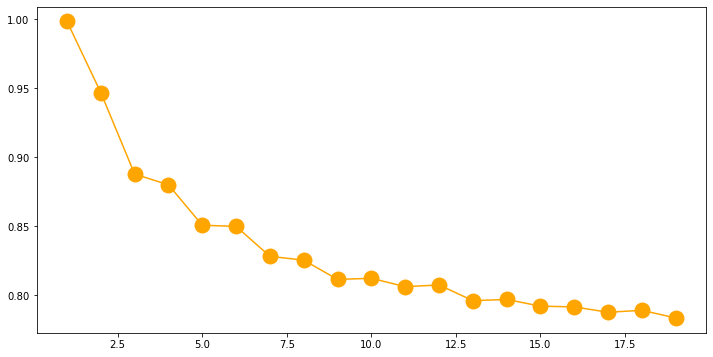

In [49]:
from sklearn.neighbors import KNeighborsClassifier

# train the model
X_train = feature_data_train.to_numpy()
y_train = target_data_train.to_numpy()
y_train = y_train.reshape(len(y_train),)

list_acc_score = []
for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_predict_train = knn.predict(X_train)
    list_acc_score.append(accuracy_score(y_train, y_predict_train))

print(list_acc_score)

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(1, 20), y=list_acc_score, color='orange')
sns.scatterplot(x=range(1, 20), y=list_acc_score, s=300, color='orange')

K = 1 is the best, possibly because the boundary between this target value is clear.

## 4. Evaluation

### 4.1. Logistic Regression

Accuracy Score for Training Data is 0.7722744881018262
Precision Score for Training Data is 0.7602614379084968
Recall Score for Training Data is 0.7995600769865273
F1 Score for Training Data is 0.7794157062449745
ROC AUC Score for Training Data is 0.7720997266024255


<AxesSubplot:>

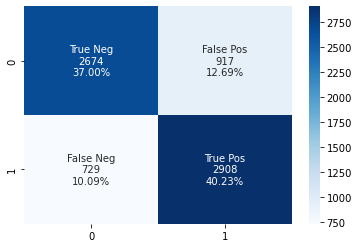

In [50]:
#Training Model
y_predict_train = logreg.predict(X_train)

print('Accuracy Score for Training Data is {}'.format(accuracy_score(y_train, y_predict_train)))
print('Precision Score for Training Data is {}'.format(precision_score(y_train, y_predict_train)))
print('Recall Score for Training Data is {}'.format(recall_score(y_train, y_predict_train)))
print('F1 Score for Training Data is {}'.format(f1_score(y_train, y_predict_train)))
print('ROC AUC Score for Training Data is {}'.format(roc_auc_score(y_train, y_predict_train)))

cf_matrix = confusion_matrix(y_train, y_predict_train)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Accuracy Score for Testing Data is 0.7711426726920594
Precision Score for Testing Data is 0.74802671523983
Recall Score for Testing Data is 0.8073394495412844
F1 Score for Testing Data is 0.7765521588402143
ROC AUC Score for Testing Data is 0.7716722692999042


<AxesSubplot:>

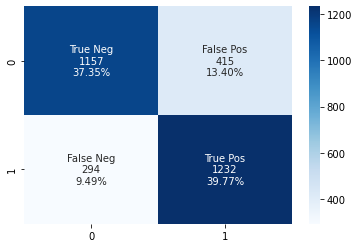

In [51]:
#Testing Model

# prepare prediction result on test data
X_test = feature_data_test.to_numpy()
y_predict_test = logreg.predict(X_test)

# ground truth target
y_test = target_data_test.to_numpy()
y_test = y_test.reshape(len(y_test),)

print('Accuracy Score for Testing Data is {}'.format(accuracy_score(y_test, y_predict_test)))
print('Precision Score for Testing Data is {}'.format(precision_score(y_test, y_predict_test)))
print('Recall Score for Testing Data is {}'.format(recall_score(y_test, y_predict_test)))
print('F1 Score for Testing Data is {}'.format(f1_score(y_test, y_predict_test)))
print('ROC AUC Score for Testing Data is {}'.format(roc_auc_score(y_test, y_predict_test)))

cf_matrix = confusion_matrix(y_test, y_predict_test)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### 4.2. Decision Tree

Accuracy Score for Training Data is 0.9983397897066962
Precision Score for Training Data is 0.9997242900468707
Recall Score for Training Data is 0.9969755292823755
F1 Score for Training Data is 0.9983480176211453
ROC AUC Score for Training Data is 0.9983485276598456


<AxesSubplot:>

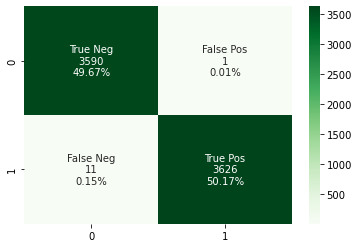

In [52]:
#Training Model
y_predict_train = dt.predict(X_train)

print('Accuracy Score for Training Data is {}'.format(accuracy_score(y_train, y_predict_train)))
print('Precision Score for Training Data is {}'.format(precision_score(y_train, y_predict_train)))
print('Recall Score for Training Data is {}'.format(recall_score(y_train, y_predict_train)))
print('F1 Score for Training Data is {}'.format(f1_score(y_train, y_predict_train)))
print('ROC AUC Score for Training Data is {}'.format(roc_auc_score(y_train, y_predict_train)))

cf_matrix = confusion_matrix(y_train, y_predict_train)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')

Accuracy Score for Testing Data is 0.8014848289218851
Precision Score for Testing Data is 0.7933032839665164
Recall Score for Testing Data is 0.8073394495412844
F1 Score for Testing Data is 0.8002598246183826
ROC AUC Score for Testing Data is 0.8015704881294208


<AxesSubplot:>

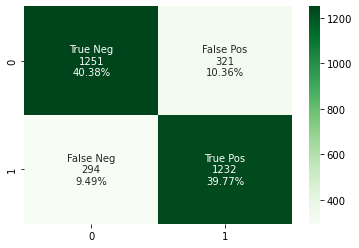

In [53]:
#Testing Model

# prepare prediction result on test data
X_test = feature_data_test.to_numpy()
y_predict_test = dt.predict(X_test)

# ground truth target
y_test = target_data_test.to_numpy()
y_test = y_test.reshape(len(y_test),)

print('Accuracy Score for Testing Data is {}'.format(accuracy_score(y_test, y_predict_test)))
print('Precision Score for Testing Data is {}'.format(precision_score(y_test, y_predict_test)))
print('Recall Score for Testing Data is {}'.format(recall_score(y_test, y_predict_test)))
print('F1 Score for Testing Data is {}'.format(f1_score(y_test, y_predict_test)))
print('ROC AUC Score for Testing Data is {}'.format(roc_auc_score(y_test, y_predict_test)))

cf_matrix = confusion_matrix(y_test, y_predict_test)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')

### 4.3. Random Forest

Accuracy Score for Training Data is 0.9983397897066962
Precision Score for Training Data is 0.9975295086467197
Recall Score for Training Data is 0.9991751443497388
F1 Score for Training Data is 0.9983516483516482
ROC AUC Score for Training Data is 0.9983344393427892


<AxesSubplot:>

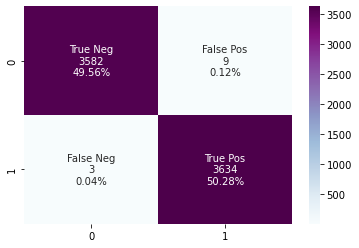

In [54]:
#Training Model
y_predict_train = rf.predict(X_train)

print('Accuracy Score for Training Data is {}'.format(accuracy_score(y_train, y_predict_train)))
print('Precision Score for Training Data is {}'.format(precision_score(y_train, y_predict_train)))
print('Recall Score for Training Data is {}'.format(recall_score(y_train, y_predict_train)))
print('F1 Score for Training Data is {}'.format(f1_score(y_train, y_predict_train)))
print('ROC AUC Score for Training Data is {}'.format(roc_auc_score(y_train, y_predict_train)))

cf_matrix = confusion_matrix(y_train, y_predict_train)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='BuPu')

Accuracy Score for Testing Data is 0.856036152356359
Precision Score for Testing Data is 0.8580901856763926
Recall Score for Testing Data is 0.8479685452162516
F1 Score for Testing Data is 0.8529993408042189
ROC AUC Score for Testing Data is 0.8559181148473115


<AxesSubplot:>

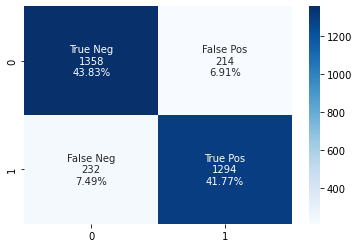

In [55]:
#Testing Model

# prepare prediction result on test data
X_test = feature_data_test.to_numpy()
y_predict_test = rf.predict(X_test)

# ground truth target
y_test = target_data_test.to_numpy()
y_test = y_test.reshape(len(y_test),)

print('Accuracy Score for Testing Data is {}'.format(accuracy_score(y_test, y_predict_test)))
print('Precision Score for Testing Data is {}'.format(precision_score(y_test, y_predict_test)))
print('Recall Score for Testing Data is {}'.format(recall_score(y_test, y_predict_test)))
print('F1 Score for Testing Data is {}'.format(f1_score(y_test, y_predict_test)))
print('ROC AUC Score for Testing Data is {}'.format(roc_auc_score(y_test, y_predict_test)))

cf_matrix = confusion_matrix(y_test, y_predict_test)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### 4.4. K-Nearest Neighbour

Accuracy Score for Training Data is 0.9983397897066962
Precision Score for Training Data is 0.9983502886994776
Recall Score for Training Data is 0.9983502886994776
F1 Score for Training Data is 0.9983502886994776
ROC AUC Score for Training Data is 0.9983397224616852


<AxesSubplot:>

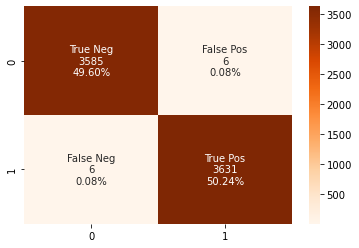

In [56]:
#Training Model
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_predict_train = knn.predict(X_train)

print('Accuracy Score for Training Data is {}'.format(accuracy_score(y_train, y_predict_train)))
print('Precision Score for Training Data is {}'.format(precision_score(y_train, y_predict_train)))
print('Recall Score for Training Data is {}'.format(recall_score(y_train, y_predict_train)))
print('F1 Score for Training Data is {}'.format(f1_score(y_train, y_predict_train)))
print('ROC AUC Score for Training Data is {}'.format(roc_auc_score(y_train, y_predict_train)))

cf_matrix = confusion_matrix(y_train, y_predict_train)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Oranges')

Accuracy Score for Testing Data is 0.8285990961910911
Precision Score for Testing Data is 0.7828311540648095
Recall Score for Testing Data is 0.9023591087811271
F1 Score for Testing Data is 0.8383561643835618
ROC AUC Score for Testing Data is 0.8296782821259325


<AxesSubplot:>

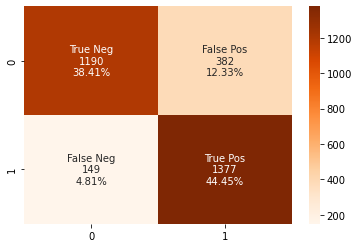

In [57]:
#Testing Model

# prepare prediction result on test data
X_test = feature_data_test.to_numpy()
y_predict_test = knn.predict(X_test)

# ground truth target
y_test = target_data_test.to_numpy()
y_test = y_test.reshape(len(y_test),)

print('Accuracy Score for Testing Data is {}'.format(accuracy_score(y_test, y_predict_test)))
print('Precision Score for Testing Data is {}'.format(precision_score(y_test, y_predict_test)))
print('Recall Score for Testing Data is {}'.format(recall_score(y_test, y_predict_test)))
print('F1 Score for Testing Data is {}'.format(f1_score(y_test, y_predict_test)))
print('ROC AUC Score for Testing Data is {}'.format(roc_auc_score(y_test, y_predict_test)))

cf_matrix = confusion_matrix(y_test, y_predict_test)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Oranges')

## 5. Model Comparison 

Logistic Regression: 0.736712 (0.102094)
Decision Tree: 0.718939 (0.172876)
Random Forest: 0.816254 (0.148283)
K-Nearest Neighbour: 0.778278 (0.113668)


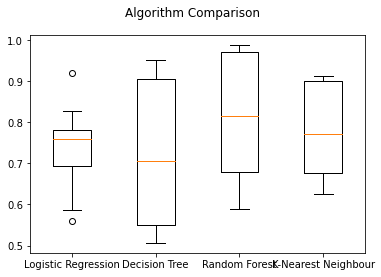

In [85]:
from sklearn import model_selection

#prepare models
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('K-Nearest Neighbour', KNeighborsClassifier()))

#evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_over_smote, y_over_smote, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

#boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## 6. Conclusion

Dari keempat model machine learning yang digunakan, model Random Forest dan K-Nearest Neighbor mempunyai nilai akurasi yang paling tinggi dengan masing-masing 81.62% dan 77.82%. Adapun observasi masing-masing model adalah sebagai berikut:

* Logistic Regression: model ini merupakan model yang paling fit antara hasil dari data training dan data testing, dengan masing-masing memberikan akurasi 77.22% dan 77.11%. Artinya model ini merupakan model yang paling sederhana dibandingkan yang lain sehingga mempunyai akurasi paling rendah saat training, namun juga yang paling konsisten.


* Decision Tree: model ini memberikan akurasi paling tinggi pada data training, mencapai 99%. Artinya model yang dipapai sangat cocok dan akurat memprediksi target pada data training. Namun pada data testing, akurasi turun menjadi 80%, lebih rendah dibandingkan Random Forest dan K-Nearest Neighbor. Sedikit overfitting, namun pada nilai yang masih dapat diterima.


* Random Forest: secara teori, model ini merupakan pengembangan dari Decision Tree. Akurasi pada data training memberikan hasil yang sama seperti Decision Tree, yaitu 99%. Cukup kompleks untuk mengikuti pola target. Pada data testing, akurasi turun menjadi 85%, lebih tingi dibandingkan Decision Tree yang artinya berhasil mengurangi noise tanpa mengurangi kompleksitas model. Random Forest juga memberikan nilai akurasi yang paling baik, menjadikan model yang layak digunakan selanjutnya pada dataset ini dibandingkan model lain. Random Forest memberikan hasil yang baik disebabkan model ini dapat mempertimbangkan seluruh feature yang paling berpengaruh terhadap Churn pada root, sehingga hasil yang diperoleh lebih baik dari Decision Tree.


* K-Nearest Neighbor: model ini melibatkan perhitungan jarak, sehingga menghabiskan waktu pemodelan paling lama. Akurasi pada data training memberikan hasil yang impresif, yaitu 99% sedikit di bawah Decision Tree dan Random Forest. Pada data testing, akurasi yang dihasilkan adalah 82%, di atas Decision Tree. Artinya waktu pemodelan yang lama dan model yang lebih sederhana dibandingkan yang lain namun memberikan hasil yang cukup akurat dan bisa diandalkan. Bersama Random Forest, model KNN bisa digunakan selanjutnya pada dataset ini.  